In [10]:
import numpy as np
import scipy.stats
import scipy.optimize as op
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import math
import pandas as pd
import seaborn as sns
import random as rand
import os
import collections
import itertools


# iPython magic command for inline figures. If this command is not given, figures are generated in windows.
# An asterisk appears in the cell prompt (i.e. "In [*]:"), and the kernel stalls until the window is closed.
%matplotlib inline

print "Required modules loaded \n\n" 

Required modules loaded 




In [182]:
###
### Create a class to hold and store the data 
###

class StellarObject:
    def __init__(self, name, data):
        self.name = name
        self.data = data
        self.edges = []
        self.density = []
        self.densityError = []
        self.normDenisty = []
        self.normDensityError = []
        self.binsize = []
        self.results = {}
        


###
### Here we define some functions that are needed for the rest of the data analyses.
###

# Rebin a histogram so there are at least a certain amount of counts per bin (mininbin).
def histrebin(mininbin, counts, edges):
    counts2, edges2 = np.zeros(1), np.zeros(1)
    i, countsum, firstbin_flag = 0, 0, 1
    edges2[0] = edges[0]

    for x in counts:
        countsum = countsum + x
        i = i + 1
        # The sum over counts in remaining bins ensures that no bins
        # with counts less than our limit at the end are obtained.
        if countsum >= mininbin and (sum(counts[i:]) >= mininbin or i == len(counts)):
            # If this is the first bin satisfying the requirement,
            # do not append but replace bin 0 with countsum instead.
            if firstbin_flag == 1:
                counts2[0] = countsum
                # Now that the first bin was read this can be switched off.
                firstbin_flag = 0
            else:
                counts2=np.append(counts2, countsum)

            edges2 = np.append(edges2, edges[i])
            countsum = 0        

    return counts2, edges2



###
### define our functional models
###

def add_emmision_line(E, lineNormalisation, lineEnergie):
    sigma = 0.06*np.sqrt(lineEnergie)
    return scipy.stats.norm.pdf(E, lineEnergie, sigma)*lineNormalisation

def add_emmision_line_integrated(E, lineNormalisation, lineEnergie):
    sigma = 0.06*np.sqrt(lineEnergie)
    return scipy.stats.norm.cdf(E, lineEnergie, sigma)*lineNormalisation



def model_ULX1(parm, E): 
    def func(E):
        if E <= Ebk:
            return N0 * (E)**(-Gamma1)
        else:
            return N0 * (Ebk)**(-Gamma1) * (E / Ebk)**(-Gamma2)
    N0 = parm[0]
    Ebk = parm[1]
    Gamma1 = parm[2]
    Gamma2 = parm[3]
    if not np.iterable(E):
        return func(E)
    else:
        return [func(indivE) for indivE in E]


def model_ULX2(parm, EList):
    def func(E):
        return N0 * (E)**(-Gamma) * np.exp(-E / Ecut)
        
    N0 = parm[0]
    Ecut = parm[1]
    Gamma = parm[2]
    return func(EList)

    
def model_ULX2_integrated(parm, EList):
    def func(E):
        return -N0 * E**(1-Gamma) * scipy.special.expn(Gamma, E/Ecut)
        
    N0 = parm[0]
    Ecut = parm[1]
    Gamma = parm[2]
    return func(EList)


def model_SNR(parm, EList):
    def func(E):
            return N0 * E**(-Gamma)
        
    N0 = parm[0]
    Gamma = parm[1]
    Si13Strength = parm[2]
    Si15Strength = parm[3]
    FeStrength = parm[4]

    return func(EList) + add_emmision_line(EList, Si13Strength, 1.83) + \
add_emmision_line(EList, Si15Strength, 2.4) + add_emmision_line(EList, FeStrength, 6.7)


def model_SNR_integrated(parm, EList):
    def func(E):
            return N0 * E**(1-Gamma)/(1-Gamma)
        
    N0 = parm[0]
    Gamma = parm[1]
    Si13Strength = parm[2]
    Si15Strength = parm[3]
    FeStrength = parm[4]

    return func(EList) + add_emmision_line_integrated(EList, Si13Strength, 1.83) + \
add_emmision_line_integrated(EList, Si15Strength, 2.4) + add_emmision_line_integrated(EList, FeStrength, 6.7)


def model_XRB(parm, EList):
    def func(E):
            return N0 * (E)**(2) / ( np.exp(E / KbT) - 1)
        
    N0 = parm[0]
    KbT = parm[1]
    return func(EList)


def model_AGN1(parm, EList):
    def func(E):
            return N0 * E**(-Gamma)
        
    N0 = parm[0]
    Gamma = parm[1]
    return func(EList)


def model_AGN1_integrated(parm, EList):
    def func(E):
            return N0 * E**(1-Gamma)/(1-Gamma)
        
    N0 = parm[0]
    Gamma = parm[1]
    return func(EList)


def model_power(parm, EList):
    def func(E):
            return N0 * E**(-Gamma)
        
    N0 = parm[0]
    Gamma = parm[1]
    return func(EList)



def model_AGN2(parm, EList):
    def func(E):
            return N0 * E**(-Gamma)
        
    N0 = parm[0]
    Gamma = parm[1]
    FeStrength = parm[2]
    return func(EList) + add_emmision_line(EList, FeStrength, 6.7)


def model_AGN2_integrated(parm, EList):
    def func(E):
            return N0 * E**(1-Gamma)/(1-Gamma)
        
    N0 = parm[0]
    Gamma = parm[1]
    FeStrength = parm[2]
    return func(EList) + add_emmision_line_integrated(EList, FeStrength, 6.7)


def ChiSq_Integ(parm, ebins, yval, dy, source): # the weighted least-squares for an array of upper and lower bin edges
    # (xval1 and xval2) fitted with the integral over the bin of the generic model my_fit_model
    i = 0
    ymod = np.zeros(len(yval))
    if True:
        model = eval("model_"+source)
        for energy in ebins[:-1]:
            ymod[i], ymoderr = scipy.integrate.quad(lambda x: model(parm, x),ebins[i],ebins[i+1])
            ymod[i] = ymod[i]/(ebins[i+1]-ebins[i])  # we now divide by the bin width to match the counts density
            # units of our data
            i=i+1
            
    else:
        model_integ = eval("model_{}_integrated".format(source))
        model = eval("model_"+source)
        
    
        for energy in ebins[:-1]:
    
            ymod[i] = model_integ(parm, ebins[i+1]) - model_integ(parm, ebins[i]) 
            A, ymoderr = scipy.integrate.quad(lambda x: model(parm, x), ebins[i], ebins[i+1])
                     
            
            ymod[i] = ymod[i]/(ebins[i+1]-ebins[i])  # we now divide by the bin width to match the counts density
            # units of our data
            i=i+1
        

    return sum(pow((yval-ymod)/dy,2))


def LogLikelihood_Pois_Integ(parm, ebins, yval, source): # the -ve log-likelihood or an array of bin edges, fitted with 
    # the integral over the bin of the generic model my_fit_model.  Input yval must be counts and not counts per
    # unit x-value
    i = 0
    ymod = np.zeros(len(yval))
    model = eval("model_"+source)

    for energy in ebins[:-1]:
        ymod[i], ymoderr = scipy.integrate.quad(lambda x: model(parm, x),ebins[i],ebins[i+1])
        # we don't normalise by bin width since the rate parameter is set by the model and needs to be counts per bin
        i=i+1
        
    pd = scipy.stats.poisson(ymod) #we define our Poisson distribution
    return -sum(np.log(pd.pmf(yval)))


def printParmError(parm, error, model):
    if(model == "ULX1"):
        print "N0: {} +/- {}\nEbk: {} +/- {}\nGamma1: {} +/- {}\nGamma2: {} +/- {}\n".format(
        parm[0], error[0], parm[1], error[1], parm[2], error[2], parm[3], error[3])
    
    elif(model == "ULX2"):
        print "N0: {} +/- {}\nEcut: {} +/- {}\nGamma: {} +/- {}\n".format(
        parm[0], error[0], parm[1], error[1], parm[2], error[2])
    
    elif(model == "SNR"):
        print "N0: {} +/- {}\Gamma: {} +/- {}\nSi13Strength(at 1.83keV): {} +/- {}\nSi15Strength (at 2.4keV): {} +/- {}\nFeStrength (at 6.7keV): {} +/- {}\n".format(
        parm[0], error[0], parm[1], error[1], parm[2], error[2], parm[3], error[3], parm[4], error[4])
        
    elif(model == "XRB"):
        print "N0: {} +/- {}\nKbT: {} +/- {}\n".format(
        parm[0], error[0], parm[1], error[1])
       
    elif(model == "AGN1"):
        print "N0: {} +/- {}\nGamma: {} +/- {}\n".format(
        parm[0], error[0], parm[1], error[1])
        
    elif(model == "AGN2"):
        print "N0: {} +/- {}\nGamma: {} +/- {}\nFeStrength (at 6.4keV): {} +/- {}\n".format(
        parm[0], error[0], parm[1], error[1], parm[1], error[1])
        
    elif(model == "power"):
        print "N0: {} +/- {}\nGamma: {} +/- {}\n".format(
        parm[0], error[0], parm[1], error[1])
    




print "Classes and functions loaded \n"

Classes and functions loaded 



In [162]:
def LogLikelihood_Pois_Integ(parm, ebins, yval, source): # the -ve log-likelihood or an array of bin edges, fitted with 
    # the integral over the bin of the generic model my_fit_model.  Input yval must be counts and not counts per
    # unit x-value
    i = 0
    ymod = np.zeros(len(yval))
    model = eval("model_"+source)
    
    for energy in ebins[:-1]:
        ymod[i], ymoderr = scipy.integrate.quad(lambda x: model(parm, x),ebins[i],ebins[i+1])
        # we don't normalise by bin width since the rate parameter is set by the model and needs to be counts per bin
        i=i+1
        
    pd = scipy.stats.poisson(ymod) #we define our Poisson distribution
#     print [round(x,4) for x in  yval]
#     print pd.pmf(yval)
#     print yval  
#     print ymod
#     print ebins
    return -sum(np.log(pd.pmf(yval)))



source = "ULX1"
startingParm = [1, 7, 1.8, 2.8]
stellarObject = stellarObjects[2]
# print LogLikelihood_Pois_Integ(startingParm, stellarObject.edges, stellarObject.counts, source)
result = op.minimize(LogLikelihood_Pois_Integ, startingParm, args=(stellarObject.edges, stellarObject.counts, source))            
print result

      fun: 22.938776056998226
 hess_inv: array([[  5.22651611e-01,  -3.56229245e-04,  -1.98280750e-02,
          1.37845279e-03],
       [ -3.56229245e-04,   2.70750124e-04,  -1.61308439e-04,
          1.27178714e-03],
       [ -1.98280750e-02,  -1.61308439e-04,   5.08773255e-03,
         -1.53576034e-03],
       [  1.37845279e-03,   1.27178714e-03,  -1.53576034e-03,
          8.00896168e-03]])
      jac: array([  1.66893005e-06,   7.75575638e-04,   9.53674316e-07,
         1.95264816e-04])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 381
      nit: 42
     njev: 63
   status: 2
  success: False
        x: array([ 145.31581498,    1.02016125,   -5.73090875,    1.69122607])


In [13]:
data = np.genfromtxt("Schefold_energies.txt", dtype=float, skip_header=0, autostrip=True, names=["Object#", "Flux"])

sources = {i:[] for i in range(1,11)}
for source, dataPoint in data:
    sources[source].append(dataPoint)
    
stellarObjects = [StellarObject("StellarObject #{}".format(i), sources[i]) for i in range(1, 11)]

print "Data loaded \n"

Data loaded 



# error is same as in PS4 BLA BLA BLA
Eerst convert ik hist naar een cdf, 

In [157]:
# edgesDict, densityDict, errorDict, binsizeDict = {}, {}, {}, {}
minNCounts = 20 

###
### Bin and rebin the data
###
for stellarObject in stellarObjects:
    data = stellarObject.data
    counts, edges = np.histogram(data, bins=100, range=[np.min(data),np.max(data)], density=False)
    counts, edges = histrebin(minNCounts, counts, edges)

    assert len(counts) == len(counts[counts>=minNCounts])
    
    ###
    ### Calculate parameters
    ###
    binsize = np.diff(edges) # calculates the width of each bin
    dens = counts/binsize # determines the count densities
    err = np.sqrt(counts)/binsize # calculate the errors: remember the error is based on the counts,         


    ###
    ### Save data and renormalize
    ###
    stellarObject.edges = edges
    stellarObject.centres = (edges[0:len(counts)] + edges[1:len(counts)+1])/2
    stellarObject.normDensity = dens/max(dens)
    stellarObject.normDensityError = err/max(dens)
    stellarObject.density = dens
    stellarObject.densityError = err
    stellarObject.binsize = binsize
    stellarObject.counts = counts


print "Data processed"

Data processed


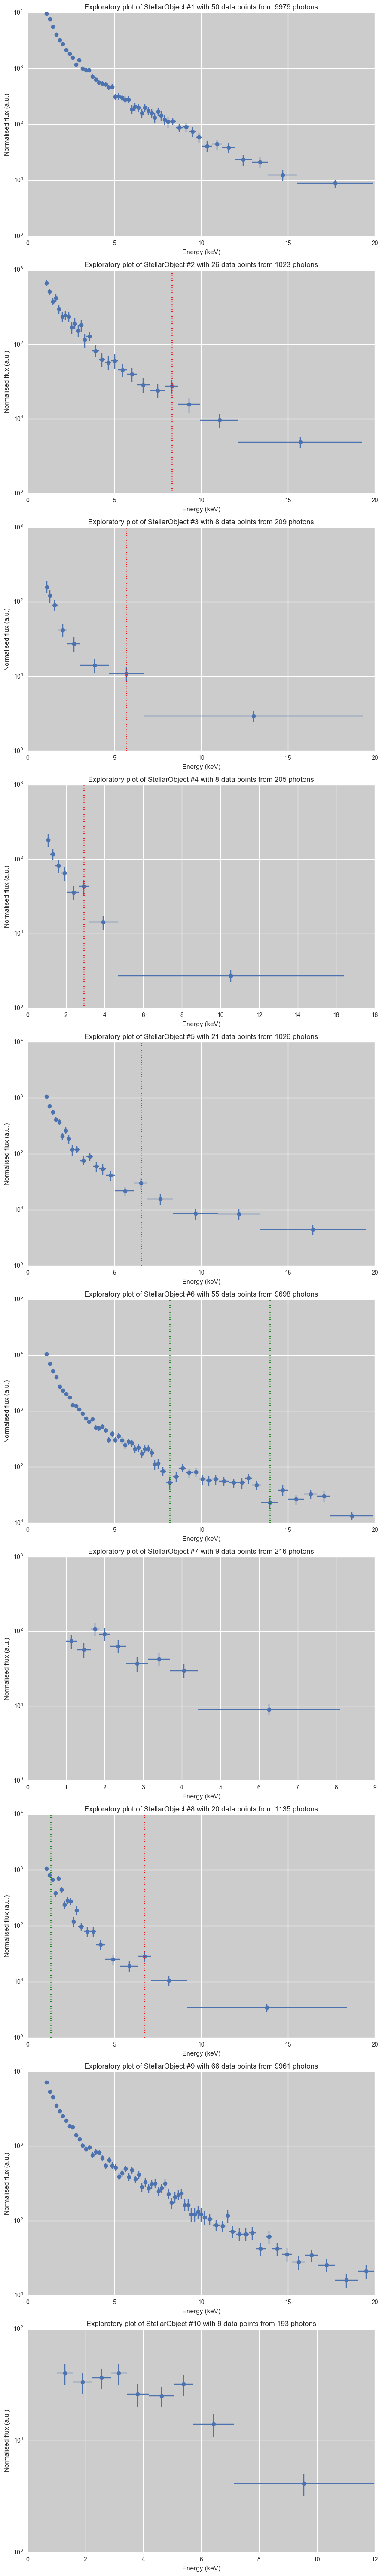

In [178]:
NStellerObjects = len(stellarObjects)
f, axes = plt.subplots(NStellerObjects, 1, figsize=(9, 6*NStellerObjects))
for i in range(NStellerObjects):
    ax = axes[i]
    stellarObject = stellarObjects[i]
    
    ###
    ### Make the plot
    ###
    ax.errorbar(stellarObject.centres, stellarObject.density, xerr=stellarObject.binsize/2,
                 yerr=stellarObject.densityError, fmt="o", label="Data")
    ax.set_xlabel("Energy (keV)")
    ax.set_ylabel("Normalised flux (a.u.)")
    ax.set_title("Exploratory plot of {} with {} data points from {} photons".format(stellarObject.name, len(stellarObject.density), len(stellarObject.data)))
    ax.patch.set_facecolor('0.8')
    ax.grid(True, color='w', linestyle='-', linewidth=1)
    ax.set_yscale('log')
       
    
f.set_tight_layout(True)
plt.show()

# Fit
Dan vit ik hem aan verschillende modellen


In [180]:
sourceList = ["ULX1", "ULX2", "SNR", "XRB", "AGN1", "AGN2"]
sourceList = ["ULX1", "ULX2", "power"]
# sourceList = ["SNR"]

colorsList = itertools.cycle(cm.rainbow(np.linspace(0, 1, len(sourceList))))

for stellarObject in stellarObjects:
    startingHeight = stellarObject.density[0]
    stellarObject.startingParamDict = {"ULX1":[1, 7, 1.8, 2.8], \
                         "ULX2":[startingHeight, 8.8, 2], \
                         "SNR":[startingHeight, 2.5, .1, .1, .01], \
                         "XRB":[startingHeight, 1.4], \
                         "AGN1":[startingHeight, 2.2], \
                         "AGN2":[startingHeight, 1.6, .3],\
                          "power":[startingHeight, 3]}

    stellarObject.boundDict = {"ULX1": ((startingHeight/3, None), (5, 10), (1.4, 2.2), (2.4, 3.2)), \
                "ULX2":((startingHeight/3, None), (4, 10), (1.5, 3.2)), \
                 "SNR":((startingHeight/3, None), (2.2, 2.9), (0, None), (0, None), (0, None)), \
                 "XRB":((startingHeight/3, None), (.6, 1.6)), \
                 "AGN1":((startingHeight/3, None), (2, 2.7)), \
                 "AGN2":((startingHeight/3, None), (1.5, 2.2), (0, None)),\
                "power":((startingHeight/3, None), (1.5, 3))}


Starting annalysis



===========================StellarObject #1   (9979 data points)===========================
ULX1
Minimum Chi-squared: 59.3581523032 for 46 d.o.f.
The goodness of fit is: 0.0893188054307
Parameters:  [  1.20252205e+04   5.53119688e+00   2.12562162e+00   3.04676734e+00]
Took 40 evaluations
<====================== possible fit

ULX2
Minimum Chi-squared: 52.5084190832 for 47 d.o.f.
The goodness of fit is: 0.269098032852
Parameters:  [  1.29974709e+04   8.58836172e+00   1.85863025e+00]
Took 40 evaluations
<====================== possible fit

power
Minimum Chi-squared: 202.159583936 for 48 d.o.f.
The goodness of fit is: 8.07106922314e-21
Parameters:  [  1.31299508e+04   2.31679199e+00]
Took 30 evaluations




===========================StellarObject #2   (1023 data points)===========================
ULX1
Minimum Chi-squared: 16.0379620354 for 22 d.o.f.
The goodness of fit is: 0.813997248036
Parameters:  [ 768.21842015    5.29461898    1.56661586    2.4       ]
Took 28 

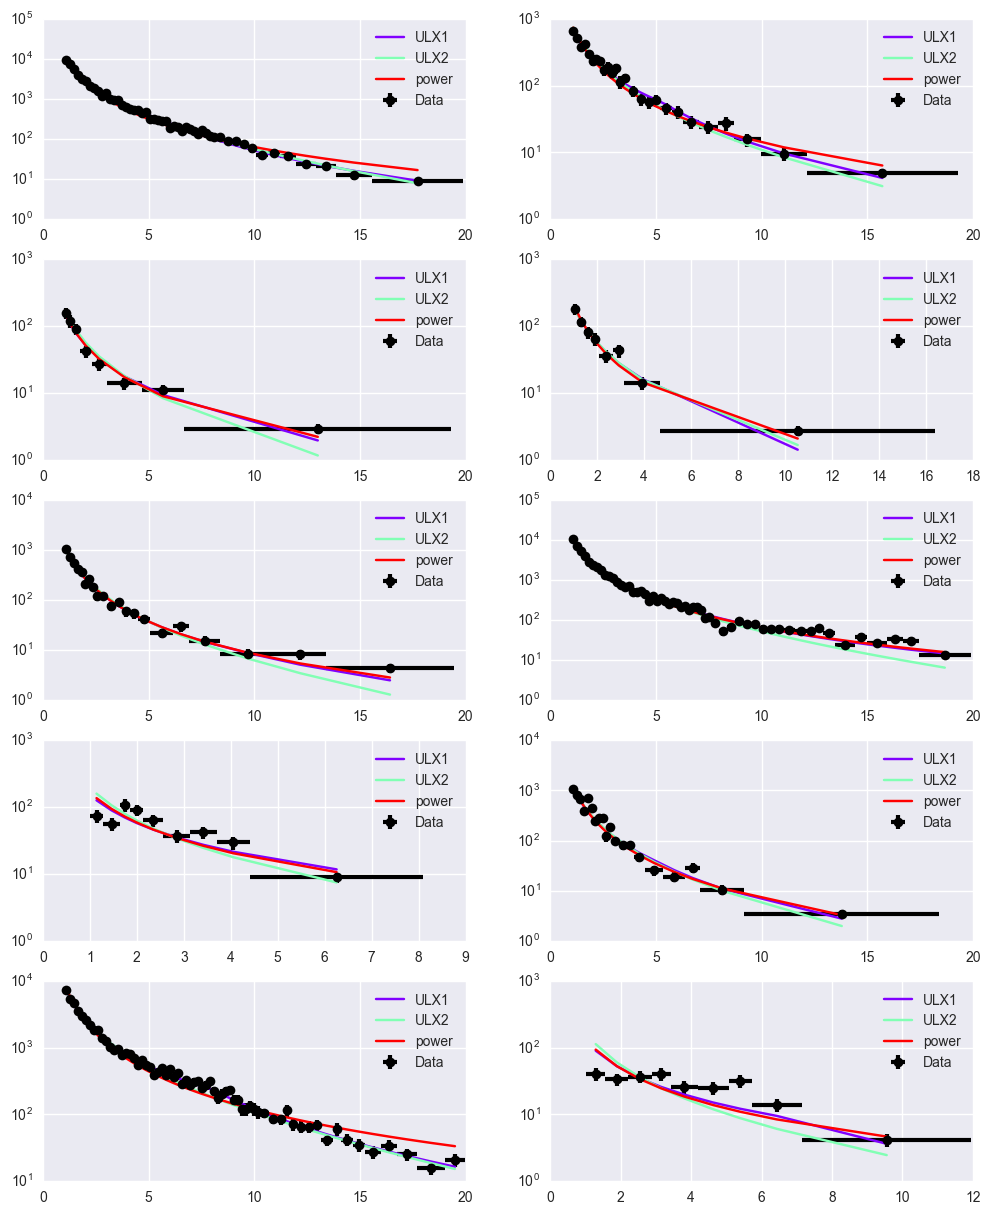

Analyses complete


In [185]:
print "Starting annalysis"

f, axes = plt.subplots(5,2,figsize=(12,15))

for i in range(5):
    for j in range(2):
        ax = axes[i][j]
        k = 2 * i + j
        stellarObject = stellarObjects[k]
        
        print "\n\n\n==========================={}   ({} data points)===========================".format(
            stellarObject.name, len(stellarObject.data))
        
        for source in sourceList:
            startingParm = stellarObject.startingParamDict[source]
            specificBounds = stellarObject.boundDict[source]

            if len(stellarObject.data) > 1000:
                result = op.minimize(ChiSq_Integ, startingParm, args=(stellarObject.edges, stellarObject.density, 
                                                                      stellarObject.densityError, source),
                                     bounds=specificBounds, options={"maxiter":100})            
            else:
                result = op.minimize(LogLikelihood_Pois_Integ, startingParm, args=(stellarObject.edges, stellarObject.counts, source),
                                     bounds=specificBounds, options={"maxiter":100})            
                

            ###
            ### Get usefull info from the fit such as pval and used parameters
            ### Save the result
            ###
            ml_vals = result["x"]
            ml_func = result["fun"]
            stellarObject.results[source] = result
        
            ###
            ### Plot the fits
            ###
            xList = stellarObject.centres
            yList = [eval("model_"+source)(ml_vals, x) for x in xList]         
#             ax.plot(xList, yList, linestyle="steps-mid", color=next(colorsList), label=source)
            ax.plot(xList, yList, color=next(colorsList), label=source)

            
            ###
            ### Output results
            ###
            pval = scipy.stats.chi2.sf(ml_func, df=len(stellarObject.density) - len(startingParm))
            print source
            print "Minimum Chi-squared: {} for {} d.o.f.".format(ml_func,len(stellarObject.density)-len(startingParm))
            print "The goodness of fit is: {}".format(pval)
            print "Parameters: ", ml_vals
            print "Took {} evaluations".format(result["nit"])
            if pval>0.05:
                print "<====================== possible fit"
            print ""

        ###    
        ### Plot original 
        ###
#         ax.errorbar(stellarObject.centres, stellarObject.normDensity, xerr=stellarObject.binsize/2., 
#                     yerr=stellarObject.normDensityError, lw=3, color="k", label="Data", fmt="o")

        ax.errorbar(stellarObject.centres, stellarObject.density, xerr=stellarObject.binsize/2., 
                    yerr=stellarObject.densityError, lw=3, color="k", label="Data", fmt="o")

        ax.set_yscale('log')

        ax.legend()
plt.show()
print "Analyses complete"

<table style="width:100%">
  <tr>
    <th>Firstname</th>
    <th>Lastname</th> 
    <th>Age</th>
  </tr>
  <tr>
    <td>Jill</td>
    <td>Smith</td> 
    <td>50</td>
  </tr>
  <tr>
    <td>Eve</td>
    <td>Jackson</td> 
    <td>94</td>
  </tr>
</table>

For StellarObject #1 the best fitting model is: Ultra-luminous X-ray source with exponentially cut-off power-law. 
It has a chisqrd of 52.5084190832 with 47 d.o.f. 
This model gives a goodness of fit of 0.269098032852.    
N0: 12997.4709469 +/- 4.97379915032e-06
Ecut: 8.5883617175 +/- 0.00162287960848
Gamma: 1.85863024939 +/- -0.0313299608479

For StellarObject #2 the best fitting model is: Ultra-luminous X-ray source with break. 
It has a chisqrd of 16.0379620354 with 22 d.o.f. 
This model gives a goodness of fit of 0.813997248036.    
N0: 768.218420152 +/- -3.5527136788e-07
Ebk: 5.29461898499 +/- -3.5527136788e-06
Gamma1: 1.56661585702 +/- -0.00178914660864
Gamma2: 2.4 +/- 8.24622787832

For StellarObject #3 the best fitting model is: Power law witout shit. 
It has a chisqrd of 22.9387760567 with 6 d.o.f. 
This model gives a goodness of fit of 0.000817245536196.    
N0: 168.520648117 +/- -5.3290705182e-06
Gamma: 1.69122415291 +/- 5.3290705182e-06

For StellarObject #4 the best fittin

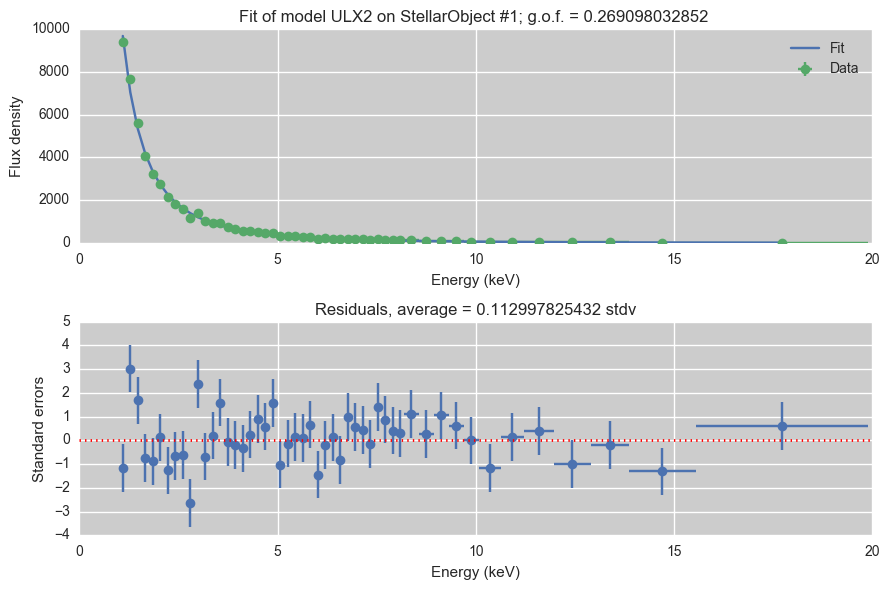

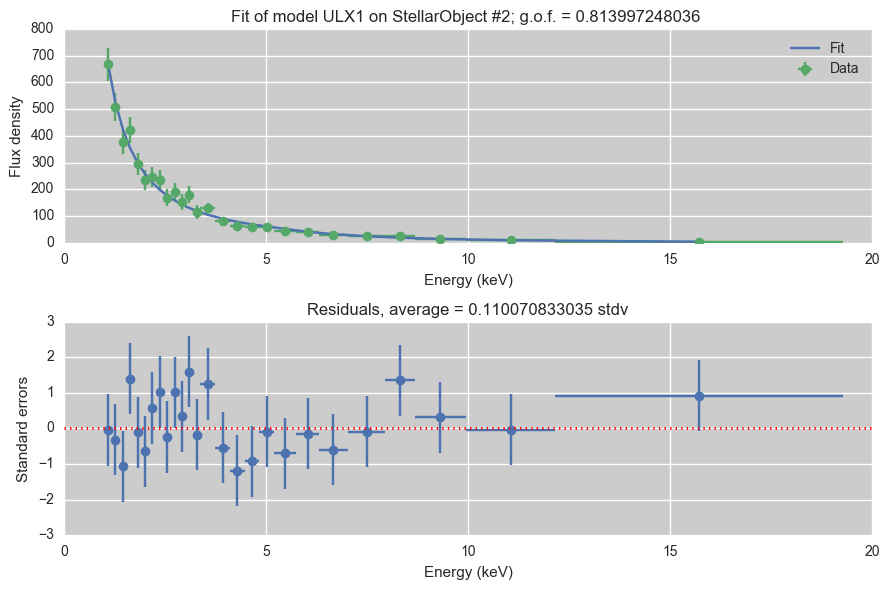

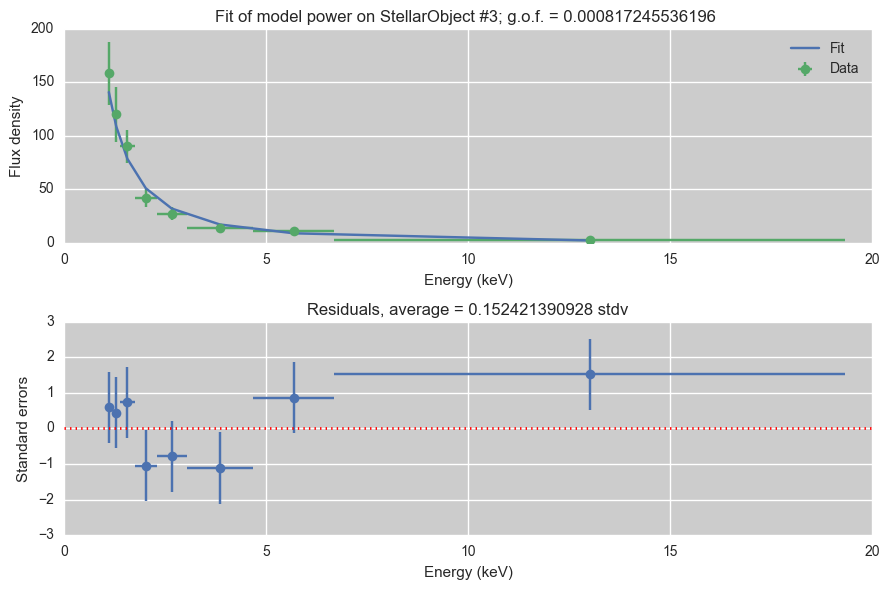

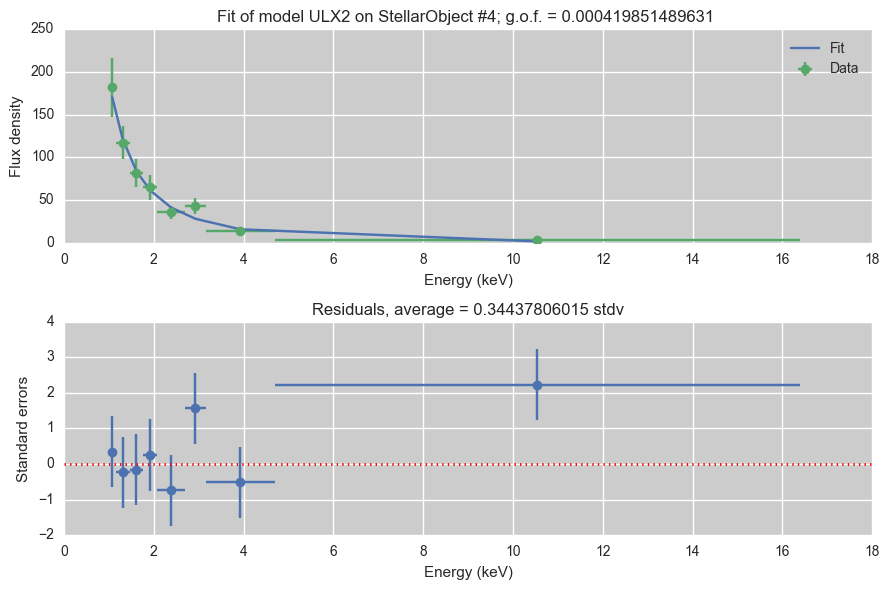

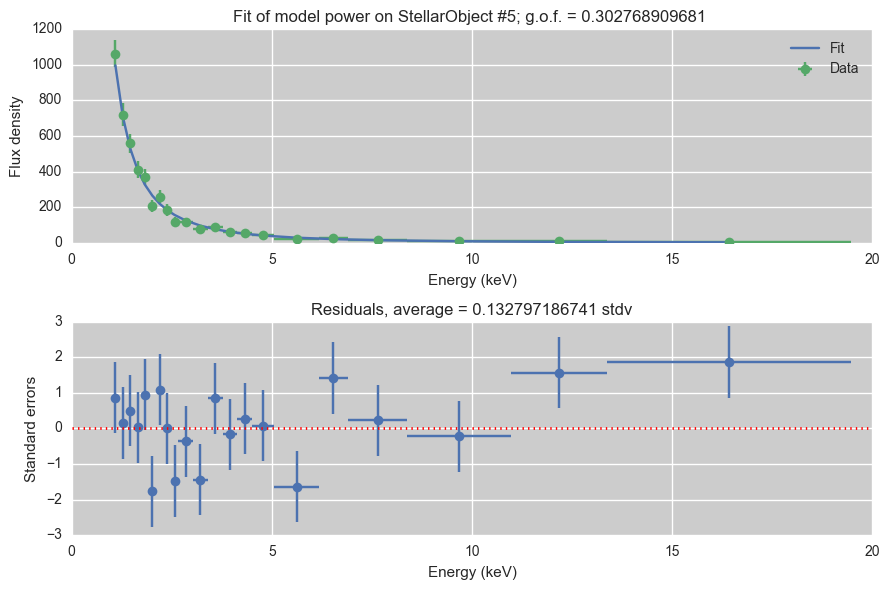

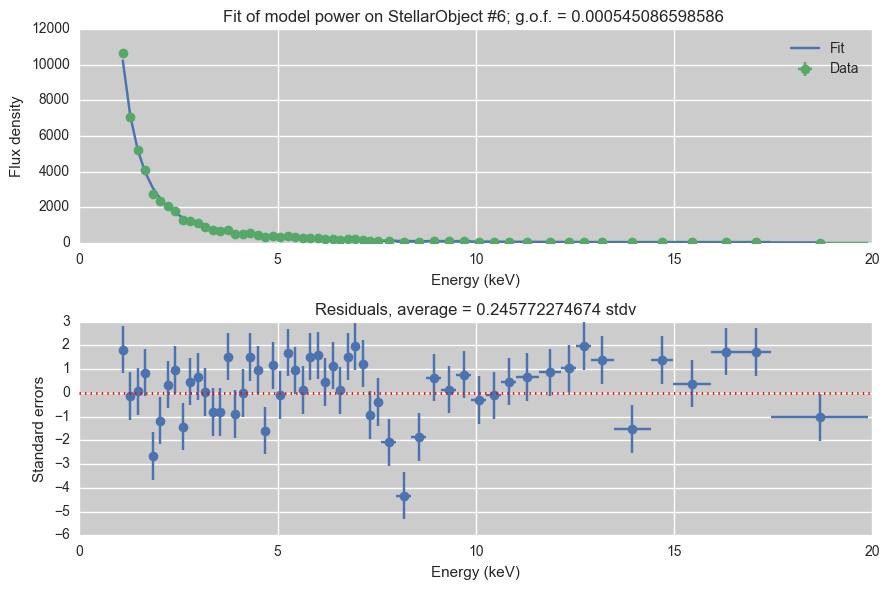

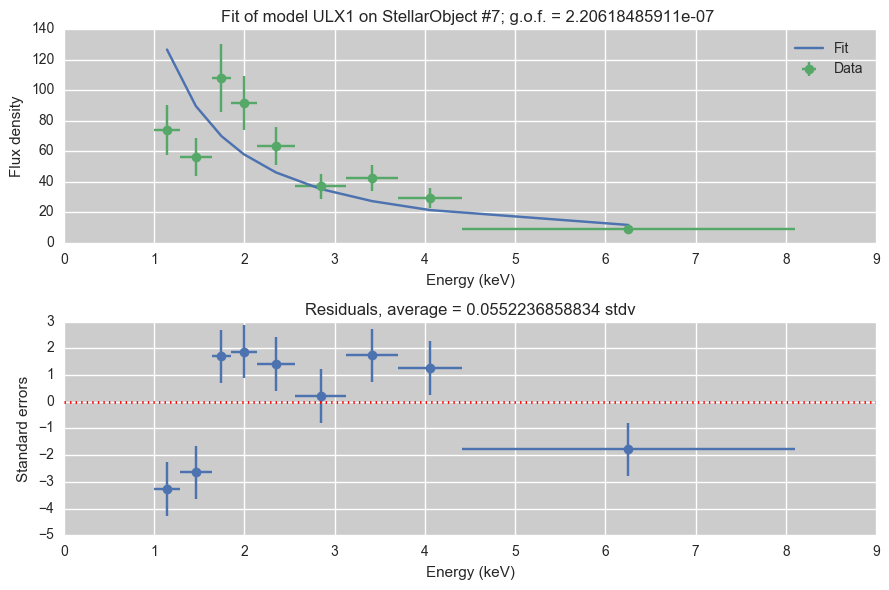

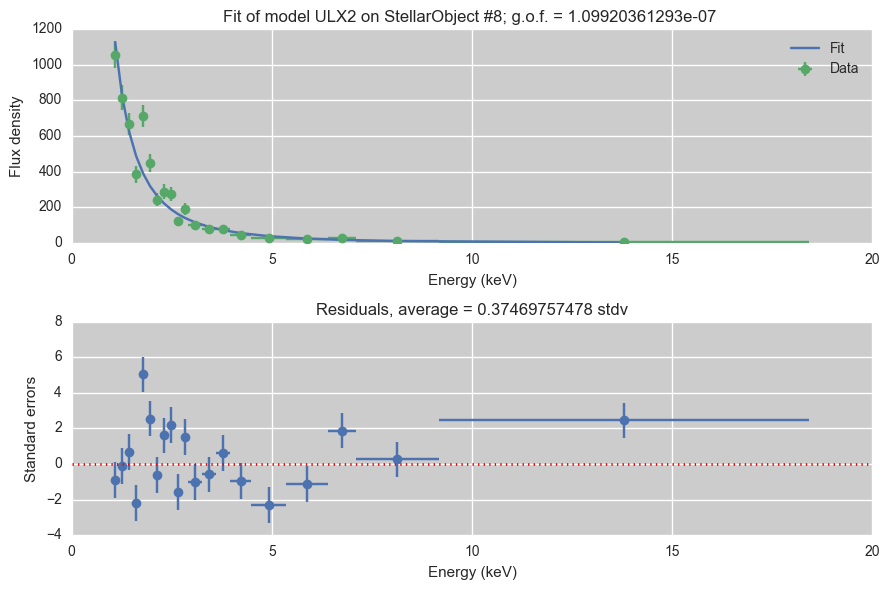

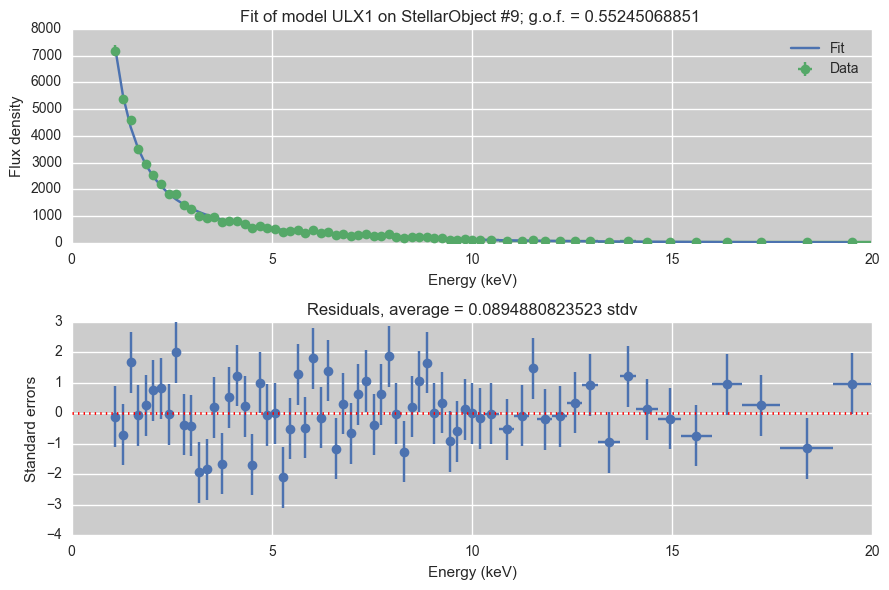

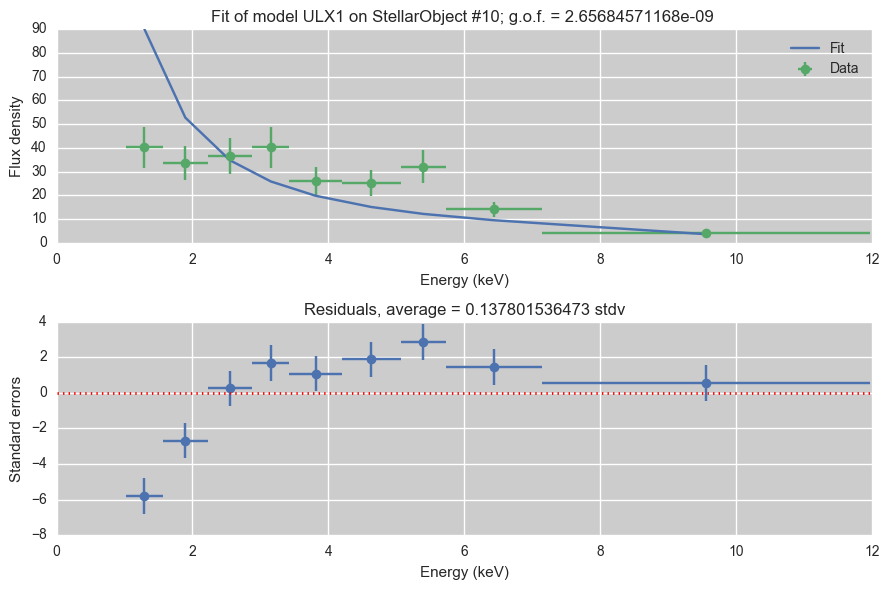

In [188]:
modelNameDict = {"ULX1": "Ultra-luminous X-ray source with break", 
                "ULX2": "Ultra-luminous X-ray source with exponentially cut-off power-law", 
                "SNR": "Young supernova remnant", 
                "XRB": "Ultrasoft X-ray binaries", 
                "AGN1":"Active Galactic Nuclei (Blazer)", 
                "AGN2":"Active Galactic Nuclei (Seyfert)",
                "power":"Power law witout shit"}


for stellarObject in stellarObjects[:]:
    bestFit = np.inf
    
    ###
    ### Find wich of the models fits te data the best.
    ###
    for model in stellarObject.results.keys():
        result = stellarObject.results[model]
        
        if result["fun"] < bestFit:
            bestFit = result["fun"]
            bestFittingModel = model

            
    ###
    ### Get the parameters of the best fiting model and print them
    ###
    bestResult = stellarObject.results[bestFittingModel]
    chiSqrd = bestResult["fun"]
    parm = bestResult["x"]
    errorParm = bestResult["jac"]
    dof = len(stellarObject.density) - len(parm)
    pval = scipy.stats.chi2.sf(chiSqrd, df=len(stellarObject.density) - len(parm))

    print "For {} the best fitting model is: {}. \nIt has a chisqrd of {} with {} d.o.f. \nThis model gives a goodness of fit of {}.\
    ".format(stellarObject.name, modelNameDict[bestFittingModel],chiSqrd, dof, pval)
    printParmError(parm, errorParm, bestFittingModel)
    
    ###
    ### Make a plot of the data with the best fitting model
    ###
    f, axes = plt.subplots(2, figsize=(9,6))

    prediction = eval("model_" + bestFittingModel)(parm, stellarObject.centres)
    residual = stellarObject.density - prediction
    residual /= stellarObject.densityError
    
    axes[0].plot(stellarObject.centres, prediction, label="Fit")
    axes[0].errorbar(stellarObject.centres, stellarObject.density, xerr=stellarObject.binsize/2,
                     yerr=stellarObject.densityError, fmt="o", label="Data")
    
    axes[0].set_xlabel("Energy (keV)")
    axes[0].set_ylabel("Flux density")
    axes[0].set_title("Fit of model {} on {}; g.o.f. = {} ".format(bestFittingModel, stellarObject.name, pval))
    axes[0].legend()
    
    axes[1].errorbar(stellarObject.centres, residual, xerr=stellarObject.binsize/2, yerr=1, fmt="o")
    axes[1].set_xlabel("Energy (keV)")
    axes[1].set_ylabel("Standard errors")
    axes[1].set_title("Residuals, average = {} stdv".format(np.average(residual)))
    axes[1].axhline(0.0, color='r', linestyle='dotted', lw=2)

    for ax in axes:
        ax.patch.set_facecolor('0.8')
        ax.grid(True, color='w', linestyle='-', linewidth=1)    
    f.set_tight_layout(True)

        
    

Now we try to improve on the fits by adding emission/absorbtion lines and freeing up stuff

In [ ]:
# stellarObjects[0].possibleEmissionLines = []
# stellarObjects[0].possibleAbsorbtionLines = []
# stellarObjects[1].possibleEmissionLines = [8.312]
# stellarObjects[1].possibleAbsorbtionLines = []
# stellarObjects[2].possibleEmissionLines = [5.6865]
# stellarObjects[2].possibleAbsorbtionLines = []
# stellarObjects[3].possibleEmissionLines = [2.92375]
# stellarObjects[3].possibleAbsorbtionLines = []
# stellarObjects[4].possibleEmissionLines = [6.541]
# stellarObjects[4].possibleAbsorbtionLines = []
# stellarObjects[5].possibleEmissionLines = []
# stellarObjects[5].possibleAbsorbtionLines = [13.946, 8.182]
# stellarObjects[6].possibleEmissionLines = []
# stellarObjects[6].possibleAbsorbtionLines = []
# stellarObjects[7].possibleEmissionLines = [6.7453]
# stellarObjects[7].possibleAbsorbtionLines = [1.3482]
# stellarObjects[8].possibleEmissionLines = []
# stellarObjects[8].possibleAbsorbtionLines = []
# stellarObjects[9].possibleEmissionLines = []
# stellarObjects[9].possibleAbsorbtionLines = []    


#     for emissionLine in stellarObject.possibleEmissionLines:
#         ax.axvline(emissionLine, color='r', linestyle='dotted', lw=2)

#     for absorbtionLine in stellarObject.possibleAbsorbtionLines:
#         ax.axvline(absorbtionLine, color='g', linestyle='dotted', lw=2)
